# Task 1.2 extra: Feature Extraction

In [98]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [99]:
import warnings 

warnings.filterwarnings('ignore')

## Loading the new dataset

In [100]:
df = pd.read_csv('../dataset/new_customer_supermarket.csv', sep='\t', index_col=0)
df

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta
0,539993,2011-04-01 10:00:00,1.95,13313.0,22386,JUMBO BAG PINK POLKADOT,10
1,539993,2011-04-01 10:00:00,0.42,13313.0,21499,BLUE POLKADOT WRAP,25
2,539993,2011-04-01 10:00:00,0.42,13313.0,21498,RED RETROSPOT WRAP,25
3,539993,2011-04-01 10:00:00,2.10,13313.0,22379,RECYCLING BAG RETROSPOT,5
4,539993,2011-04-01 10:00:00,1.25,13313.0,20718,RED RETROSPOT SHOPPER BAG,10
...,...,...,...,...,...,...,...
363612,581587,2011-09-12 12:50:00,0.85,12680.0,22613,PACK OF SPACEBOY NAPKINS,12
363613,581587,2011-09-12 12:50:00,2.10,12680.0,22899,CHILDRENS APRON DOLLY GIRL,6
363614,581587,2011-09-12 12:50:00,4.15,12680.0,23254,CHILDRENS CUTLERY DOLLY GIRL,4
363615,581587,2011-09-12 12:50:00,4.15,12680.0,23255,CHILDRENS CUTLERY CIRCUS PARADE,4


In [101]:
df.dtypes

BasketID        int64
BasketDate     object
Sale          float64
CustomerID    float64
ProdID         object
ProdDescr      object
Qta             int64
dtype: object

In [102]:
df = df.astype({'BasketDate': 'datetime64',
                'BasketID': 'object',
                'CustomerID': 'object'})

In [103]:
import webcolors
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
colors = webcolors.CSS3_NAMES_TO_HEX.keys()

def lemmatize_descr(descr):
    # print(pos_tag(word_tokenize(descr.lower())))
    tokenized_descr = [token for token, pos in pos_tag(word_tokenize(descr.lower())) 
                       if not token in stop_words and 
                       not any(color in token for color in colors) and 
                       len(token) >= 3 and 
                       ('NN' in pos or 'JJ' in pos)]
    return ' '.join(lemmatizer.lemmatize(token) for token in tokenized_descr)

In [104]:
df['ProdDescr'] = df['ProdDescr'].apply(lemmatize_descr)
df

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta
0,539993,2011-04-01 10:00:00,1.95,13313,22386,jumbo bag polkadot,10
1,539993,2011-04-01 10:00:00,0.42,13313,21499,polkadot wrap,25
2,539993,2011-04-01 10:00:00,0.42,13313,21498,retrospot wrap,25
3,539993,2011-04-01 10:00:00,2.10,13313,22379,bag retrospot,5
4,539993,2011-04-01 10:00:00,1.25,13313,20718,retrospot shopper bag,10
...,...,...,...,...,...,...,...
363612,581587,2011-09-12 12:50:00,0.85,12680,22613,pack spaceboy napkin,12
363613,581587,2011-09-12 12:50:00,2.10,12680,22899,childrens girl,6
363614,581587,2011-09-12 12:50:00,4.15,12680,23254,childrens girl,4
363615,581587,2011-09-12 12:50:00,4.15,12680,23255,childrens circus parade,4


As the name suggests Word2Vec embeds words into vector space. Word2vec takes a text corpus as input and produce word embeddings as output.

Now we have to represent every document as a single vector. We can either average or sum over every word vector, but averaging or summing over all the words would lose the semantic and contextual meaning of the documents. Different lengths of the documents would also have an adverse effect on such operations.

One better way of doing this could be taking a weighted average of word vectors using the tf-idf weights. This can handle the variable length problem to a certain extent but cannot keep the semantic and contextual meaning of words. After doing that we can use the pairwise distances to calculate similar documents as we did in the tf-idf model.

Doc2vec is an adaptation of Word2Vec to produce vector representations of sentence/paragraph/documents. Doc2Vec can represent an entire documents into a vector, so we don’t have to take average of word vectors to create document vector.

In [105]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

unique_descrs = df['ProdDescr'].unique()
train_descrs = [TaggedDocument(words=word_tokenize(descr), tags=[i]) 
                for i, descr in enumerate(unique_descrs)]

# https://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.Doc2Vec
model = Doc2Vec(train_descrs, 
                min_count=1, 
                vector_size=100, 
                batch_words=10000, 
                dm=1,  # dm defines the training algorithm: dm=1 means ‘distributed memory’ (PV-DM) and 
                # dm=0 means ‘distributed bag of words’ (PV-DBOW). Distributed Memory model preserves 
                # the word order in a document whereas Distributed Bag of words just uses the bag of 
                # words approach, which doesn’t preserve any word order.
                alpha=0.025,  # the initial learning rate
                min_alpha=0.001,  # learning rate will linearly drop to min_alpha as training progresses
                epochs=1000, 
                workers=8)

To assess our new model, we’ll first infer new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity. Basically, we’re pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. The expectation is that we’ve likely overfit our model (i.e., all of the ranks will be less than 2) and so we should be able to find similar documents very easily. Additionally, we’ll keep track of the second ranks for a comparison of less similar documents.

In [106]:
ranks = []
for descr_id in range(len(train_descrs)):
    inferred_vector = model.infer_vector(train_descrs[descr_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [doc_id for doc_id, sim in sims].index(descr_id)
    ranks.append(rank)

In [107]:
print(Counter(ranks))

Counter({0: 3095, 1: 83, 2: 17, 3: 5, 4: 3, 1972: 1})


Basically, greater than 95% of the inferred documents are found to be most similar to itself and about 5% of the time it is mistakenly most similar to another document. Checking the inferred-vector against a training-vector is a sort of ‘sanity check’ as to whether the model is behaving in a usefully consistent manner, though not a real ‘accuracy’ value.

In [108]:
print('Description ({}): «{}»\n'.format(descr_id, ' '.join(train_descrs[descr_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), 
                     ('SECOND-MOST', 1), 
                     ('MEDIAN', len(sims) // 2), 
                     ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_descrs[sims[index][0]].words)))

Description (3203): «cream heart tlight holder»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d100,n5,w5,s0.001,t8):

MOST (3203, 0.9383770227432251): «cream heart tlight holder»

SECOND-MOST (13, 0.7418142557144165): «heart tlight holder»

MEDIAN (191, 0.20903131365776062): «retrospot round cake tin»

LEAST (3121, -0.12360741943120956): «pocket mirror woodland»



In [109]:
descrs_embeddings = model.docvecs.vectors_docs_norm

Uniform Manifold Approximation and Projection is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.

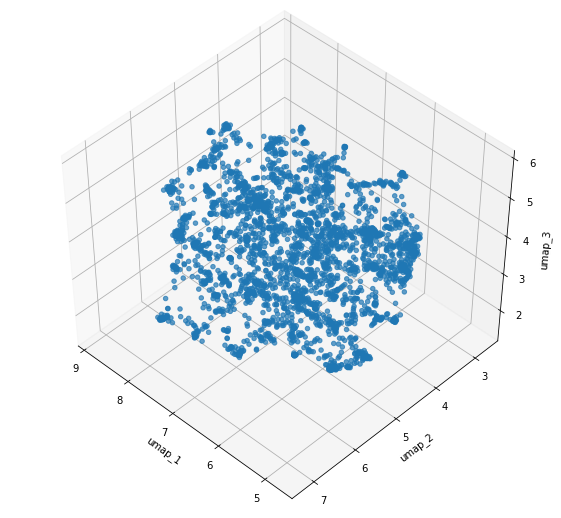

In [110]:
# https://umap-learn.readthedocs.io/en/latest/clustering.html
from umap import UMAP

umap = UMAP(n_components=3, n_neighbors=50, min_dist=0.0)
umap_descrs_embeddings = umap.fit_transform(descrs_embeddings)
fig = plt.figure(1, figsize=(8,7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(*umap_descrs_embeddings.T, s=20, alpha=0.7)
ax.set_xlabel('umap_1')
ax.set_ylabel('umap_2')
ax.set_zlabel('umap_3');

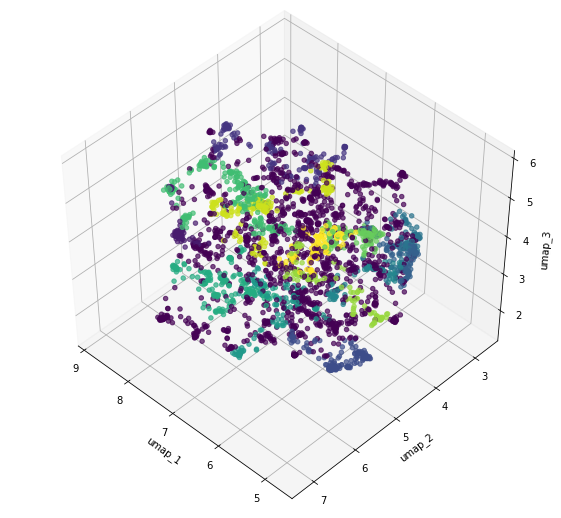

In [111]:
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=65, min_samples=10)
cluster_descrs = hdbscan.fit_predict(umap_descrs_embeddings)
fig = plt.figure(1, figsize=(8,7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(*umap_descrs_embeddings.T, c=cluster_descrs, s=20, alpha=0.7)
ax.set_xlabel('umap_1')
ax.set_ylabel('umap_2')
ax.set_zlabel('umap_3');

In [112]:
pd.DataFrame(pd.Series(cluster_descrs).value_counts(), columns=['DescrsNb']).T.sort_index(axis=1)

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12
DescrsNb,1457,78,167,150,95,101,74,132,176,255,121,117,184,97


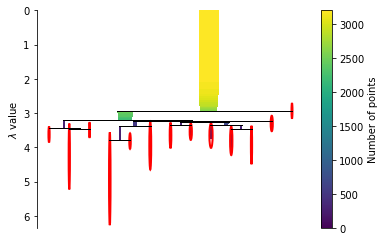

In [113]:
hdbscan.condensed_tree_.plot(select_clusters=True);

In [114]:
descrs_to_cluster = {descr: cluster for descr, cluster in zip(unique_descrs, cluster_descrs)}
df['ProdCateg'] = df.loc[:, 'ProdDescr'].map(descrs_to_cluster)
df

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta,ProdCateg
0,539993,2011-04-01 10:00:00,1.95,13313,22386,jumbo bag polkadot,10,8
1,539993,2011-04-01 10:00:00,0.42,13313,21499,polkadot wrap,25,8
2,539993,2011-04-01 10:00:00,0.42,13313,21498,retrospot wrap,25,11
3,539993,2011-04-01 10:00:00,2.10,13313,22379,bag retrospot,5,8
4,539993,2011-04-01 10:00:00,1.25,13313,20718,retrospot shopper bag,10,8
...,...,...,...,...,...,...,...,...
363612,581587,2011-09-12 12:50:00,0.85,12680,22613,pack spaceboy napkin,12,1
363613,581587,2011-09-12 12:50:00,2.10,12680,22899,childrens girl,6,-1
363614,581587,2011-09-12 12:50:00,4.15,12680,23254,childrens girl,4,-1
363615,581587,2011-09-12 12:50:00,4.15,12680,23255,childrens circus parade,4,-1


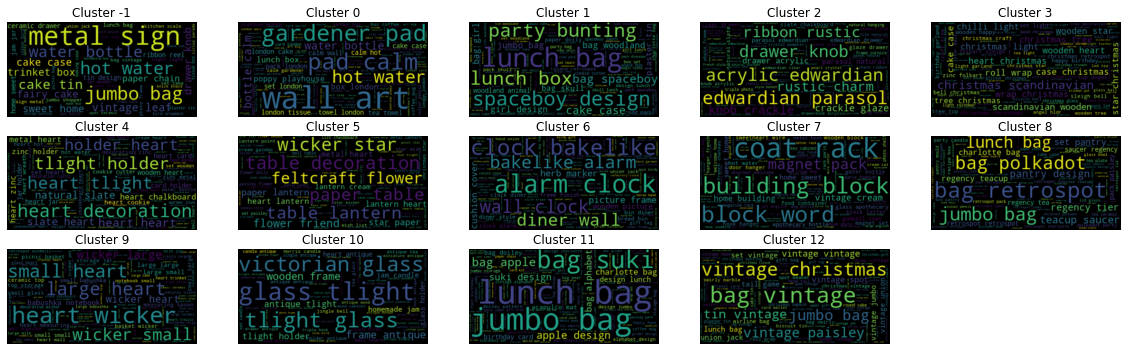

In [115]:
from wordcloud import WordCloud

plt.figure(figsize=(20,8))
wc = WordCloud()

for i, cluster in enumerate(sorted(set(hdbscan.labels_))):
    plt.subplot(4, 5, i + 1)
    wc.generate(' '.join(df[df['ProdCateg'] == cluster]['ProdDescr']))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Cluster {}'.format(cluster))
    plt.axis('off')

In [116]:
df['TotSale'] = df['Sale'] * df['Qta']

In [117]:
for i in sorted(set(hdbscan.labels_)):
    col = 'categ_{}'.format(i)
    df_temp = df[df['ProdCateg'] == i]
    df.loc[:, col] = df_temp['TotSale']
    df[col].fillna(0, inplace=True)
df

,BasketID,BasketDate,Sale,CustomerID,ProdID,ProdDescr,Qta,ProdCateg,TotSale,categ_-1,...,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,categ_11,categ_12
0,539993,2011-04-01 10:00:00,1.95,13313,22386,jumbo bag polkadot,10,8,19.50,0.0,...,0.0,0.0,0.0,0.0,0.0,19.5,0.0,0.0,0.0,0.0
1,539993,2011-04-01 10:00:00,0.42,13313,21499,polkadot wrap,25,8,10.50,0.0,...,0.0,0.0,0.0,0.0,0.0,10.5,0.0,0.0,0.0,0.0
2,539993,2011-04-01 10:00:00,0.42,13313,21498,retrospot wrap,25,11,10.50,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5,0.0
3,539993,2011-04-01 10:00:00,2.10,13313,22379,bag retrospot,5,8,10.50,0.0,...,0.0,0.0,0.0,0.0,0.0,10.5,0.0,0.0,0.0,0.0
4,539993,2011-04-01 10:00:00,1.25,13313,20718,retrospot shopper bag,10,8,12.50,0.0,...,0.0,0.0,0.0,0.0,0.0,12.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363612,581587,2011-09-12 12:50:00,0.85,12680,22613,pack spaceboy napkin,12,1,10.20,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363613,581587,2011-09-12 12:50:00,2.10,12680,22899,childrens girl,6,-1,12.60,12.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363614,581587,2011-09-12 12:50:00,4.15,12680,23254,childrens girl,4,-1,16.60,16.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363615,581587,2011-09-12 12:50:00,4.15,12680,23255,childrens circus parade,4,-1,16.60,16.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
temp = df.groupby(['CustomerID', 'BasketID'], as_index=False)['TotSale'].sum()
basket_sale = temp.rename(columns={'TotSale': 'TotBasketSale'})

for i in sorted(set(hdbscan.labels_)):
    col = 'categ_{}'.format(i)
    temp = df.groupby(['CustomerID', 'BasketID'], as_index=False)[col].sum()
    basket_sale.loc[:, col] = temp

basket_sale

,CustomerID,BasketID,TotBasketSale,categ_-1,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,categ_11,categ_12
0,12347.0,542237,475.39,157.54,0.00,21.70,0.0,0.00,19.80,0.0,110.40,12.50,76.25,10.2,33.00,0.00,34.00
1,12347.0,549222,636.25,338.00,0.00,24.90,15.0,0.00,0.00,0.0,47.70,10.20,73.65,36.0,0.00,7.80,83.00
2,12347.0,556201,382.52,45.96,0.00,0.00,0.0,0.00,0.00,0.0,98.10,0.00,138.90,20.4,13.16,15.00,51.00
3,12347.0,562032,584.91,78.50,0.00,35.20,0.0,0.00,0.00,0.0,234.00,0.00,51.25,0.0,30.56,0.00,155.40
4,12347.0,573511,1294.32,372.02,0.00,21.70,0.0,23.40,26.70,0.0,251.40,0.00,325.18,60.0,26.32,16.80,170.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16918,18283.0,579673,220.31,77.83,0.00,29.49,0.0,0.00,0.00,0.0,0.00,0.00,43.84,0.0,0.00,46.77,22.38
16919,18283.0,580872,208.00,56.14,0.78,37.95,0.0,0.00,0.00,0.0,2.55,0.00,25.61,0.0,0.00,40.23,44.74
16920,18287.0,554065,765.28,311.08,0.00,0.00,0.0,0.00,53.10,15.0,17.40,0.00,255.60,75.6,0.00,37.50,0.00
16921,18287.0,570715,1001.32,514.60,0.00,0.00,0.0,163.56,9.36,19.8,0.00,10.08,174.72,0.0,81.12,0.00,28.08


In [119]:
extra_customer_profile = basket_sale.groupby('CustomerID')['TotBasketSale'].agg(['sum', 'mean'])
extra_customer_profile.rename(columns={'mean': 'Savg'}, inplace=True)

for i in sorted(set(hdbscan.labels_)):
    col = 'categ_{}'.format(i)
    extra_customer_profile.loc[:,col] = basket_sale.groupby('CustomerID')[col].sum() / extra_customer_profile['sum'] * 100

extra_customer_profile.drop('sum', axis=1, inplace=True)
extra_customer_profile

,Savg,categ_-1,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,categ_11,categ_12
CustomerID,,,,,,,,,,,,,,,
12347.0,599.701667,30.800315,0.000000,3.946407,0.416874,1.784220,1.292309,0.000000,20.610248,0.630869,18.487804,3.518416,2.863646,1.914285,13.734607
12348.0,261.480000,76.538677,0.000000,7.490694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.970629,0.000000,0.000000,0.000000,0.000000
12349.0,1457.550000,49.563308,0.000000,3.478440,0.000000,4.142568,5.948338,0.000000,0.000000,4.389558,23.134712,2.377277,0.000000,1.855168,5.110631
12350.0,294.400000,59.239130,0.000000,6.725543,0.000000,0.000000,6.725543,0.000000,0.000000,0.000000,20.584239,0.000000,0.000000,0.000000,6.725543
12352.0,210.901667,38.106226,0.000000,9.900349,0.000000,9.459385,1.580515,1.173533,1.185387,13.181498,16.558270,1.327633,2.109988,5.417217,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,180.600000,53.626800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.611296,8.471761,0.000000,0.000000,0.000000,21.290144,0.000000
18281.0,80.820000,0.000000,0.000000,41.945063,0.000000,0.000000,0.000000,0.000000,0.000000,18.930958,0.000000,0.000000,0.000000,39.123979,0.000000
18282.0,88.300000,31.036240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.223103,7.644394,7.219706,2.853907,10.022650


## Data Normalization

In [138]:
log_extra_customer_profile = extra_customer_profile.copy(deep=True)
log_extra_customer_profile['Savg'] = np.log10(log_extra_customer_profile['Savg'])
log_extra_customer_profile

,Savg,categ_-1,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,categ_11,categ_12
CustomerID,,,,,,,,,,,,,,,
12347.0,2.777935,30.800315,0.000000,3.946407,0.416874,1.784220,1.292309,0.000000,20.610248,0.630869,18.487804,3.518416,2.863646,1.914285,13.734607
12348.0,2.417438,76.538677,0.000000,7.490694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.970629,0.000000,0.000000,0.000000,0.000000
12349.0,3.163623,49.563308,0.000000,3.478440,0.000000,4.142568,5.948338,0.000000,0.000000,4.389558,23.134712,2.377277,0.000000,1.855168,5.110631
12350.0,2.468938,59.239130,0.000000,6.725543,0.000000,0.000000,6.725543,0.000000,0.000000,0.000000,20.584239,0.000000,0.000000,0.000000,6.725543
12352.0,2.324080,38.106226,0.000000,9.900349,0.000000,9.459385,1.580515,1.173533,1.185387,13.181498,16.558270,1.327633,2.109988,5.417217,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,2.256718,53.626800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.611296,8.471761,0.000000,0.000000,0.000000,21.290144,0.000000
18281.0,1.907519,0.000000,0.000000,41.945063,0.000000,0.000000,0.000000,0.000000,0.000000,18.930958,0.000000,0.000000,0.000000,39.123979,0.000000
18282.0,1.945961,31.036240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.223103,7.644394,7.219706,2.853907,10.022650


## Saving the extra Customer Profile model

In [140]:
log_extra_customer_profile.to_csv('../dataset/extra_customer_profile_model.csv', sep='\t')